In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

0.0001


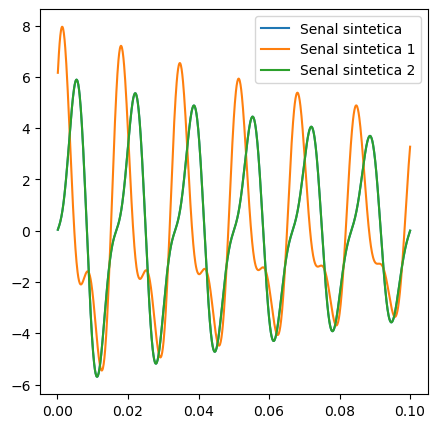

In [2]:
ceros = 0
polos = 12
t_min = 0
t_max = 0.1 # tiempo max
No_muestras = 1001
w = 2*np.pi*60
t = np.linspace(t_min, t_max, No_muestras)[1:]
dt = (t_max - t_min)/(No_muestras - 1)
print(dt)
alfa = -5
omega = w

matrix_senales = np.zeros((5, len(t)) , dtype=float)

senal = 5*np.exp(alfa*t )*np.sin(omega*t) - 2*np.exp(1.5*alfa*t)*np.sin(2*omega*t )
senal_1 = 5.3*np.exp(alfa*t)*np.sin(omega*t+ np.pi/4) + 3*np.exp(1.5*alfa*t )*np.sin(2*omega*t + np.pi/4)
senal_2 = 5*np.exp(alfa*t )*np.sin(omega*t) - 2*np.exp(1.5*alfa*t)*np.sin(2*omega*t )
senal_3 = 5*np.exp(alfa*t )*np.sin(omega*t) - 2*np.exp(1.5*alfa*t)*np.sin(2.5*omega*t )
senal_4 = 5*np.exp(alfa*t)*np.sin(omega*t) - 3*np.exp(1.7*alfa*t)*np.sin(3*omega*t )

matrix_senales[0]  =  senal
matrix_senales[1]  =  senal_1
matrix_senales[2]  =  senal_2
matrix_senales[3]  =  senal_3
matrix_senales[4]  =  senal_4

senal_sum = matrix_senales[0] + matrix_senales[1] + matrix_senales[2]

fig = plt.figure(figsize=(5,5))

plt.plot(t, senal, label = 'Senal sintetica ')
plt.plot(t, senal_1, label = 'Senal sintetica 1')
plt.plot(t, senal_2, label = 'Senal sintetica 2')
# plt.plot(t, senal_sum, label = 'Senal suma')
plt.legend()
plt.show()

In [3]:
def prony(polos, matrix_senales, t, dt):
    
    fmax = 1/(4*dt)
    matrix_dimention = len(t) - 1
    No_senales = 1 
    No_senales_1 = matrix_senales.shape[0] 
    

    r_f = polos - 1
    A = np.zeros(( No_senales_1 * matrix_dimention - (r_f * No_senales_1), polos), dtype=float) 
    B = np.zeros(( No_senales_1 * matrix_dimention - (r_f * No_senales_1), No_senales), dtype=float)
    
    A_0 = np.zeros((matrix_dimention - r_f, polos), dtype=float) 
    B_0 = np.zeros((matrix_dimention - r_f, No_senales), dtype=float)
    

    for k in range(0, No_senales_1):
        cont = 0
        for i in range(0, polos): #Columnas
            cont_1 = 0        
            for j in range(1, matrix_dimention): #Filas  
                cont_1 += 1                              
                if j < r_f :
                    pass
                else:
                    B_0[j - r_f ] = matrix_senales[k][j + 1]           
                    if j  + 1 > cont:                                    
                        A_0[j - r_f ][i]  = matrix_senales[k][j - cont] # columna 0, fila 0                 
            cont += 1

        if k < 1:
            lim_inf = k*matrix_dimention 
        else:
            lim_inf = lim_sup 

        lim_sup = matrix_dimention + lim_inf - r_f 

        A[lim_inf : lim_sup, : ] = A_0        
        B[lim_inf : lim_sup, : ] = B_0


    u =  np.linalg.pinv(A)    
    A_gorro = -1* np.dot(u, B)
    A_gorro = np.insert(A_gorro, 0, 1) 
    
    raices = np.roots(A_gorro)
    # print(raices)
    Sn = 1/dt * np.log(raices)    
    z_2 = np.where((5 / np.abs(np.real(Sn)) > dt)  & (np.abs(np.imag(Sn)) <=  fmax ))[0]
    Sn = Sn[z_2]
    print(Sn)
    
    matrix_roots =  np.zeros((matrix_dimention, Sn.shape[0]), dtype=np.complex128)
    vect_roots = np.zeros((matrix_dimention, No_senales_1), dtype=np.complex128)

    for k in range(0, No_senales_1):    
        for i in range(0, Sn.shape[0]): #columna  0 -> 4   
            for j in range(0, matrix_dimention):# fila 0-> 500                
                vect_roots[j][k] = matrix_senales[k][j]                    
                matrix_roots[j][i]  = np.exp(Sn[i]*dt*j) # columna 0, fila 0 
    
    u_root =  np.linalg.pinv(matrix_roots)
    matrix_root_gorro = np.dot(u_root, vect_roots)
    # print(matrix_roots)
    mac_root = np.abs(matrix_root_gorro)
    mac_angle = np.angle(matrix_root_gorro) 
    mac_grados = 180 * (mac_angle / np.pi)
    signal_recon = np.zeros((No_senales_1, len(t),), dtype = 'complex_')
    error = np.zeros((No_senales_1, t.shape[0] - 1))
    rms_eror = np.zeros_like(error)
    rms_senal = np.zeros_like(error)
    db = np.zeros_like(error)
    
    # for i in range(0, Sn.shape[0]):    
    #     print(f"""{np.real(Sn[i])} || {np.imag(Sn[i])} || {mac_root[i][0]} || {mac_grados[i][0]}""")
   
    # # #-------------------------------------------------------------------------------------
    for k in range(0, No_senales_1):
        for j in range(0, int(t.shape[0])):
            for i in range(0, Sn.shape[0]):     
                signal_recon[k , j] +=   matrix_root_gorro[i , k] * np.exp(Sn[i] * t[j]) 
    signal_recon = np.real(signal_recon)
    # # #-------------------------------------------------------------------------------------
          
    # print(error.shape)
    fig, ax = plt.subplots(No_senales_1, 1, figsize=(20, 15))
   
    for k in range(0, No_senales_1): 
        copy_sen = matrix_senales[k, 1:].copy()
        copy_sen_recon = signal_recon[k, :signal_recon.shape[1] - 1].copy()
        error[k,:] = copy_sen -  copy_sen_recon
        
        rms_eror[k,:] = np.sqrt(np.mean(error[k,:]**2))
        rms_senal[k,:] = np.sqrt(np.mean(matrix_senales[k,:]**2))
        db[k,:] = 10*np.log10(rms_eror[k,:] / rms_senal[k,:])
        ax[k].plot(t, matrix_senales[k, :], label='Senal Sintetica', color='blue')
        ax[k].plot(t, signal_recon[k, :], label='Senal Reconstruida', color='green')
        ax[k].grid( linestyle='-', linewidth=1)
        ax[k].hlines(y=0, xmin=0, xmax=dt * len(t), linewidth=1, linestyle='--',color='black')
        ax[k].set_title(f'Error = {round(db[k,0], 3)} db')
        ax[k].legend()
    
    fig.suptitle('Señales',  fontsize = 24,y=0.93)
    plt.show()

    
 
        

[-12.54160884+1128.03227023j -12.54160884-1128.03227023j
   4.32426383 +956.23093826j   4.32426383 -956.23093826j
  -1.15096713 +389.05218901j  -1.15096713 -389.05218901j
 -19.13168148 +734.92474393j -19.13168148 -734.92474393j]


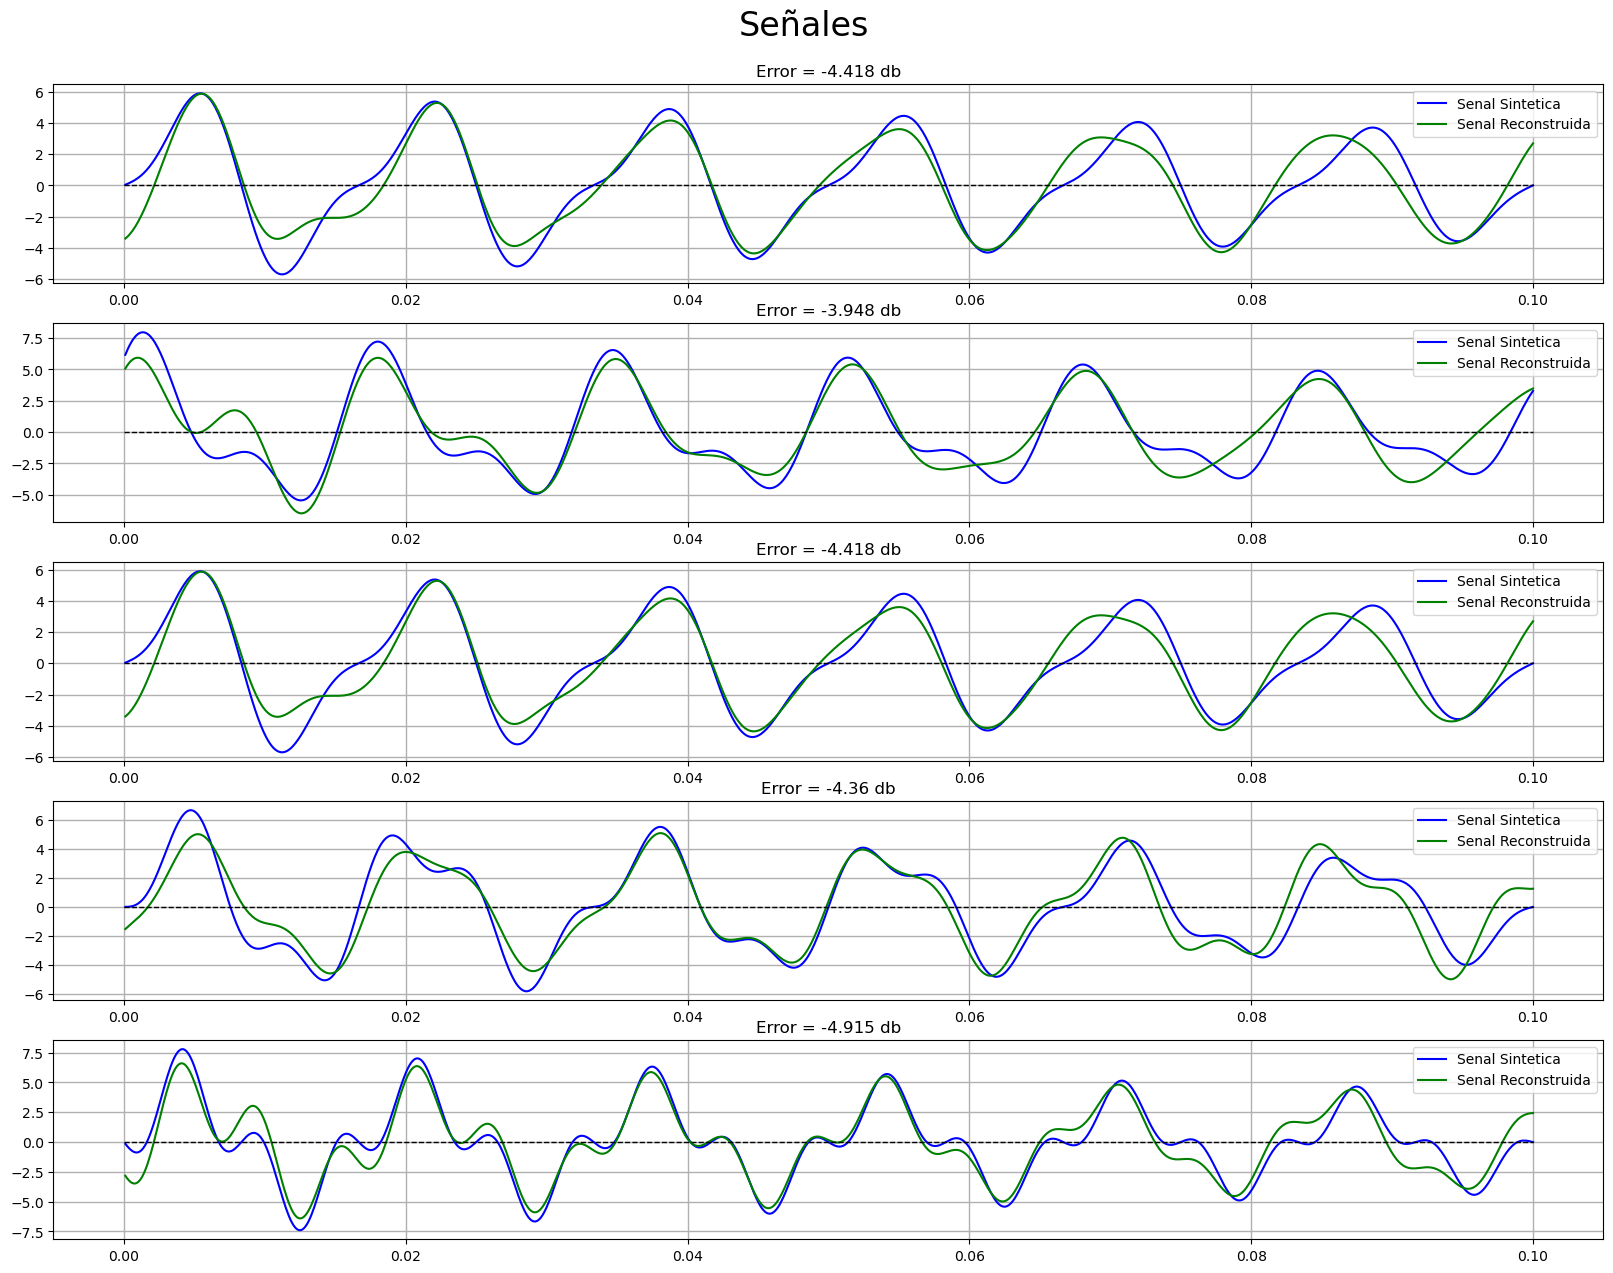

In [4]:
matrix_senales = np.zeros((5, len(t)) , dtype=float)

senal = 5*np.exp(alfa*t )*np.sin(omega*t) - 2*np.exp(1.5*alfa*t)*np.sin(2*omega*t )
senal_1 = 5.3*np.exp(alfa*t)*np.sin(omega*t+ np.pi/4) + 3*np.exp(1.5*alfa*t )*np.sin(2*omega*t + np.pi/4)
senal_2 = 5*np.exp(alfa*t )*np.sin(omega*t) - 2*np.exp(1.5*alfa*t)*np.sin(2*omega*t )
senal_3 = 5*np.exp(alfa*t )*np.sin(omega*t) - 2*np.exp(1.5*alfa*t)*np.sin(2.5*omega*t )
senal_4 = 5*np.exp(alfa*t)*np.sin(omega*t) - 3*np.exp(1.7*alfa*t)*np.sin(3*omega*t )

matrix_senales[0]  =  senal
matrix_senales[1]  =  senal_1
matrix_senales[2]  =  senal_2
matrix_senales[3]  =  senal_3
matrix_senales[4]  =  senal_4
#------------------------------------------------------------------------------------------------------------------

ceros = 0
polos = 15
No_senales = 1
t_min = 0
t_max = 0.1 # tiempo max
No_muestras = 1001 
t = np.linspace(t_min, t_max, No_muestras)[1:]

dt = (t_max - t_min)/(No_muestras - 1)

prony(polos, matrix_senales, t, dt)